# Segmentación de semilleros para plantulas

In [1]:
%config Completer.use_jedi = False

import numpy as np
import os
from PIL import Image

import tensorflow as tf

import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

## 1. Redimension de imágenes

In [2]:
def Imagen_bandas(imagen):
    from PIL import Image
    imagen_size = imagen.size
    #Ancho y Largo de la imagen
    w = imagen_size[0]
    h = imagen_size[1]

    if(w != h):
        largo = w if w > h else h
        #se crea una imagen cuadrada blanca de largo x largo
        fondo = Image.new('RGB', (largo, largo), (255, 255, 255, 255))
        #se calcula la posicion en la que se pegará la imagen original
        offset = (int(round(((largo - w) / 2), 0)), int(round(((largo - h) / 2),0)))
        fondo.paste(imagen, offset)
    else:
        print("La imagen ya es cuadrada")       
    
    return fondo

## 2. Concatenar imagenes (Real + Segmentada)

In [3]:
# Direccion de las imagenes de entrenamiento
path = 'Direccion de las imagenes de entrenamiento'
carpeta = ['original/','segmentado/']

n_path = 'Direccion de las imagenes concatenadas'

#Lee los archivos de la carpeta original
path_, paths, files = next(os.walk(path + 'original/'))
file_count = len(files)


for j in range(file_count):
    image_o = Image.open(path + carpeta[0] +'image'+str(j+1)+ '.jpg')
    image_s = Image.open(path + carpeta[1] +'image'+str(j+1)+ '.jpg')
    
    #tamaño original de la imagen
    w_i, h_i = image_o.size

    #relacion de aspecto
    r = w_i / h_i

    #Tamaño de la imagen redimensionada
    h_f = 384
    w_f = int(np.rint(r * h_f))

    #imagen redimensionada
    image_re_o = image_o.resize((w_f,h_f))
    image_re_s = image_s.resize((w_f,h_f))
    
    #imagen cuadrada con bandas blancas
    imagen_cuad_o = Imagen_bandas(image_re_o)
    image_cuad_s = Imagen_bandas(image_re_s)
    
    #concatenacion de las imagenes
    image_concat = Image.new('RGB', (imagen_cuad_o.width + image_cuad_s.width, imagen_cuad_o.height))
    image_concat.paste(imagen_cuad_o, (0, 0))
    image_concat.paste(image_cuad_s, (imagen_cuad_o.width, 0))
    
    #guardado en una carpeta
    image_concat.save(n_path + str(j+1) + '.jpeg')


## 3. Cargar imagen concatenada, dividir y convertir a tensor float 32

In [4]:
def cargar(path):
    
    #cargar y decodificar un imagen en un tensor uint8 
    imagen = tf.io.read_file(path)
    imagen = tf.image.decode_jpeg(imagen)
    
    #dividir la imagen en la original y la segmentada
    w = tf.shape(imagen)[1]
    w = w // 2
    
    imagen_in = imagen[:, :w ,:]
    imagen_seg = imagen[:, w: ,:]
    
    #convertir las imagenes a tensores float32
    imagen_in = tf.cast(imagen_in, tf.float32)
    imagen_seg = tf.cast(imagen_seg, tf.float32)
    
    return imagen_in,imagen_seg

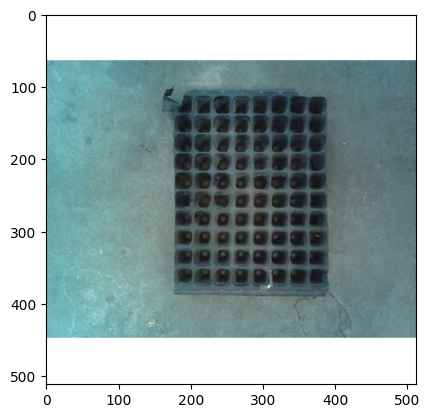

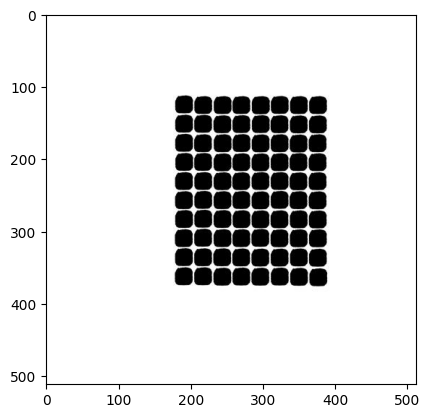

In [5]:
real, seg = cargar(n_path + "1.jpeg")

plt.figure()
plt.imshow(real / 255.0)
plt.figure()
plt.imshow(seg / 255.0)

## 4. Aplicacion de variaciones aleatorias en las imágenes

In [6]:
# Cantidad de imagenes de entrenamiento
BUFFER_SIZE = 24
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Resolucion de cada imagen
IMG_WIDTH = w_f
IMG_HEIGHT = w_f

In [7]:
#Cambiar el tamaño de imagen
def resize(imagen_in,imagen_seg,h,w):
    imagen_in = tf.image.resize(imagen_in,[h,w],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    imagen_seg = tf.image.resize(imagen_seg,[h,w],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return imagen_in,imagen_seg

In [8]:
#Recorte aleatorio
def random_crop(imagen_in,imagen_seg):
    imagen_stackeada = tf.stack([imagen_in, imagen_seg], axis=0)
    imagen_recortada = tf.image.random_crop(imagen_stackeada, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    
    return imagen_recortada[0],imagen_recortada[1]

In [9]:
#normalizacion
def normalize(imagen_in, imagen_seg):
    imagen_in = (imagen_in / 127.5) - 1
    imagen_seg = (imagen_seg / 127.5) - 1

    return imagen_in, imagen_seg

In [10]:
#Funcion para cambios aleatorios en las imágenges
@tf.function()
def random_jitter(imagen_in, imagen_seg):
    #resize a w_f x w_f
    imagen_in, imagen_seg = resize(imagen_in,imagen_seg,w_f,w_f)
    #Recortar aleatoramente
    imagen_in, imagen_seg = random_crop(imagen_in,imagen_seg)
    
    #Espejo de las imagenes con probabilidad del 50%
    if tf.random.uniform(()) > 0.5:
        imagen_in = tf.image.flip_left_right(imagen_in)
        imagen_seg = tf.image.flip_left_right(imagen_seg)
    
    #Imagen segmentada a escala de grises
    imagen_seg = tf.image.rgb_to_grayscale(imagen_seg)
    
    return imagen_in,imagen_seg

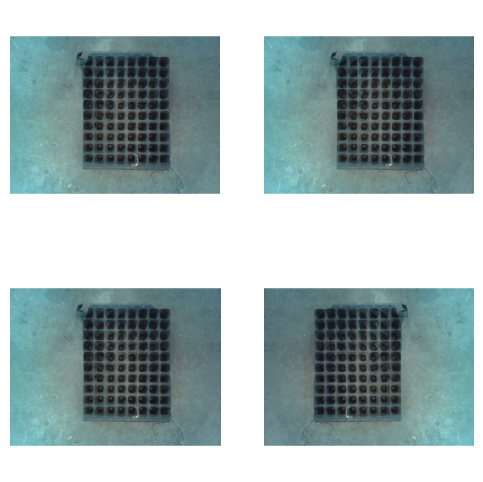

In [11]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(real, seg)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
plt.show()

## 5. Carga de imagenes de entrenamiento y test

In [12]:
def cargar_img_entrenamiento(path):
    imagen_in, imagen_seg = cargar(path)
    imagen_in, imagen_seg = random_jitter(imagen_in, imagen_seg)
    imagen_in, imagen_seg = normalize(imagen_in, imagen_seg)
    
    return imagen_in, imagen_seg

In [13]:
def cargar_img_prueba(path):
    imagen_in, imagen_seg = cargar(path)
    imagen_in, imagen_seg = resize(imagen_in, imagen_seg,IMG_HEIGHT, IMG_WIDTH)
    imagen_seg = tf.image.rgb_to_grayscale(imagen_seg)
    imagen_in, imagen_seg = normalize(imagen_in, imagen_seg)
    
    return imagen_in, imagen_seg

In [14]:
train_dataset = tf.data.Dataset.list_files(n_path + 'train/*.jpeg')
train_dataset = train_dataset.map(cargar_img_entrenamiento,
                                  num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [15]:
try:
    test_dataset = tf.data.Dataset.list_files(n_path + 'test/*.jpeg')
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files(n_path + 'val/*.jpeg')
test_dataset = test_dataset.map(cargar_img_prueba)
test_dataset = test_dataset.batch(BATCH_SIZE)

## 6. Creacion del Generador

In [16]:
OUTPUT_CHANNELS = 1

#Capa del codificador
def downsample(filters, size, apply_batchnorm=True):
    #Inicializa los pesas de la capa con un valor aleatorio de una distribucion gausiana con media=0 u std=0.02
    initializer = tf.random_normal_initializer(0.,0.02)
    #se crea el modelo
    result = tf.keras.Sequential()
    #se agrega una capa convolucional
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                              kernel_initializer = initializer, use_bias=False))
    #Se aplica la normalizacion por lotes
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())
    return result

In [17]:
#Prueba de la capa del codificador con la imagen real 
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(real, 0))
print (down_result.shape)

(1, 256, 256, 3)


In [18]:
#Capa del decodificador
def upsample(filters, size, apply_dropout=False):
    #Inicializa los pesas de la capa con un valor aleatorio de una distribucion gausiana con media=0 u std=0.02
    initializer = tf.random_normal_initializer(0.,0.02)
    #se crea el modelo
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                       kernel_initializer=initializer, use_bias=False))
    #Se aplica la normalizacion por lotes
    result.add(tf.keras.layers.BatchNormalization())
    #Droput del 50% de conexiones
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        
    result.add(tf.keras.layers.ReLU())
    return result

In [19]:
#Prueba de la capa del decodificador con la imagen real 
up_model = upsample(3,4)
up_model = up_model(down_result)
print(up_model.shape)

(1, 512, 512, 3)


In [20]:
def Generator():
    
    inputs = tf.keras.layers.Input(shape=[w_f,w_f,3])
    
    down_stack = [
        downsample(64,4,apply_batchnorm=False), #[batch_size, 256, 256, 64]
        downsample(128,4), #[batch_size, 128, 128, 128]
        downsample(256,4), #[batch_size, 64, 64, 256]
        downsample(512,4), #[batch_size, 32, 32, 512]
        downsample(512,4), #[batch_size, 16, 16, 512]
        downsample(512,4), #[batch_size, 8, 8, 512]
        downsample(512,4), #[batch_size, 4, 4, 512]
        downsample(512,4),  #[batch_size, 2, 2, 512]
        downsample(512,4)  #[batch_size, 1, 1, 512]
    ]
    
    up_stack = [
        upsample(512,4,apply_dropout=True), #[batch_size, 2, 2, 1024]
        upsample(512,4,apply_dropout=True), #[batch_size, 4, 4, 1024]
        upsample(512,4,apply_dropout=True), #[batch_size, 8, 8, 1024]
        upsample(512,4,apply_dropout=True), #[batch_size, 16, 16, 1024]
        upsample(512,4), #[batch_size, 32, 32, 512]
        upsample(256,4), #[batch_size, 64, 64, 256]
        upsample(128,4),  #[batch_size, 128, 128, 128]
        upsample(64,4)   #[batch_size, 256, 256, 128]
    ]
    
    initializer = tf.random_normal_initializer(0.,0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', 
                                           kernel_initializer=initializer, activation='tanh') #[batch_size, 512, 512,1]
    
    x = inputs
    #Unir las Skip Conection del codificador con el decodificador
    skips = []
    
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    for up,skip in zip(up_stack,skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x,skip])
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [21]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


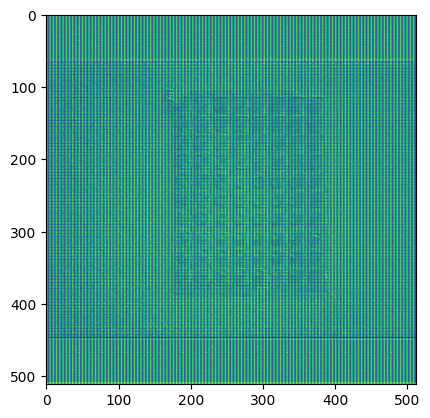

In [22]:
#prueba del funcionamiento del Generador
gen_output = generator(real[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [23]:
# Funcion de Perdida del Generador
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_out, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_out),disc_generated_out)
    
    #MAE
    l1_loss = tf.reduce_mean(tf.abs(target-gen_output))
    
    total_gen_loss = gan_loss + (LAMBDA*l1_loss)
    
    return  total_gen_loss, l1_loss, gan_loss
    

## 7. Creación del Discriminador

In [24]:
def Discriminator():
    
    initializer = tf.random_normal_initializer(0.,0.02)
    
    inp = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT,3], name='Imagen real')
    tar = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT,1], name='imagen segmentada')
    
    x = tf.keras.layers.concatenate([inp,tar]) #[batch_size, 512, 512, 4]
    
    down1 = downsample(64,4,False)(x) #[batch_size, 256, 256, 64]
    down2 = downsample(128,4)(down1) #[batch_size, 128, 128, 128]
    down3 = downsample(256,4)(down2) #[batch_size, 64, 64, 256]
        
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) #[batch_size, 34, 34, 256]
    
    conv = tf.keras.layers.Conv2D(512,4, strides=1,
                          kernel_initializer= initializer, 
                          use_bias=False)(zero_pad1) #[batch_size, 31, 31, 512]
    
    batch = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batch)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) #[batch_size, 33, 33, 512]
    
    last = tf.keras.layers.Conv2D(1,4,strides=1,
                                 kernel_initializer=initializer)(zero_pad2) #[batch_size, 30, 30, 1]
    
    return tf.keras.Model(inputs=[inp,tar], outputs=last)

In [25]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


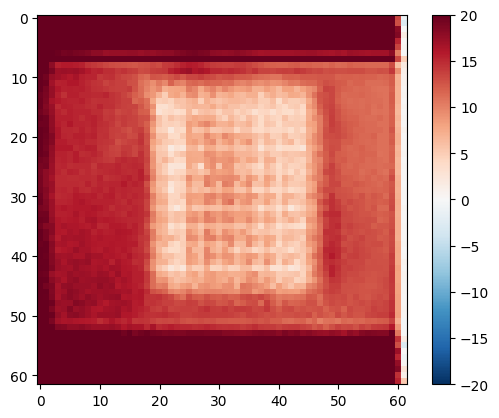

In [26]:
disc_out = discriminator([real[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [27]:
# Funcion de Perdida del Discriminador

def discriminator_loss(dicsc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(dicsc_real_output),dicsc_real_output)
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output),disc_generated_output)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss

## 8. Optimizador y punto de control

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [29]:
checkpoints_path = './training_checkpoints'

checkpoints_prefix = os.path.join(checkpoints_path,"ckpt")

checkpoints = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)


## 9. Generar imagenes durante el entrenamiento

In [30]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    
    title = ['input_image', 'target_image', 'prediction']
    
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title[i])
        
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    
    plt.show()
    

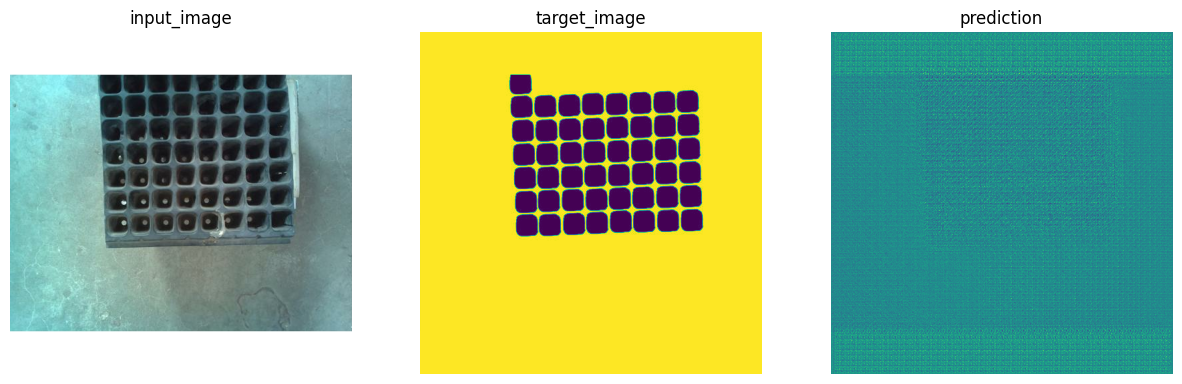

In [31]:
for example_input, example_target in test_dataset.take(1):
      generate_images(generator, example_input, example_target)

## 10. Funcion de entrenamiento

In [32]:
log_path = "logs/"

summary_writer = tf.summary.create_file_writer(
    log_path + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [33]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape(persistent=True) as gen_tape, tf.GradientTape(persistent=True) as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output,disc_generated_output)
        
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                           generator.trainable_variables)
    discriminator_gradients = gen_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                       generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                           discriminator.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//100)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//100)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//100)
        tf.summary.scalar('disc_loss', disc_loss, step=step//100)

In [35]:
# Cargar TensorBoard notebook extension.
%reload_ext tensorboard
%tensorboard --logdir {"./logs/fit/"} --host localhost

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [36]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    
    for step, (input_image,target) in train_ds.repeat().take(steps).enumerate():
        
        if (step) % 100 == 0:
            start = time.time()
            display.clear_output(wait=True)
            
            if step != 0:
                print(f"tiempo para 1000 pasos: {time.time()-start} sec/n")
            
            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")
            
        train_step(input_image, target, step)
        
        #Paso de entrenamiento
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)
            
        #Guardar (checkpoint) del modelo de entrenamiento cada 5k pasos
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

tiempo para 1000 pasos: 0.000989675521850586 sec/n


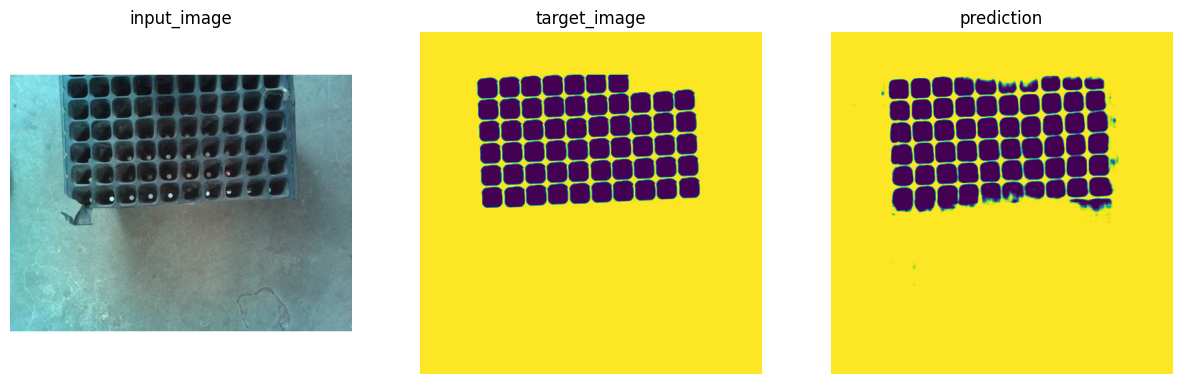

Step: 2k
..........

In [37]:
#Entrenar el modelo
fit(train_dataset, test_dataset, steps=3000)

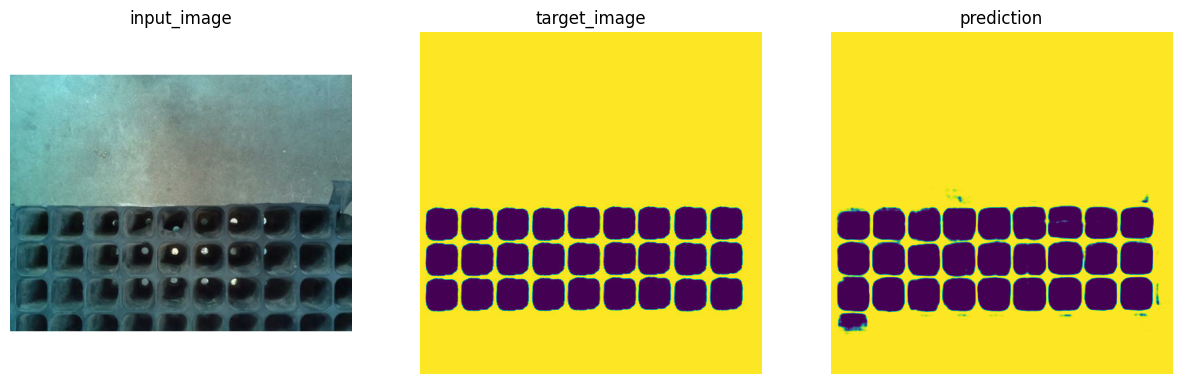

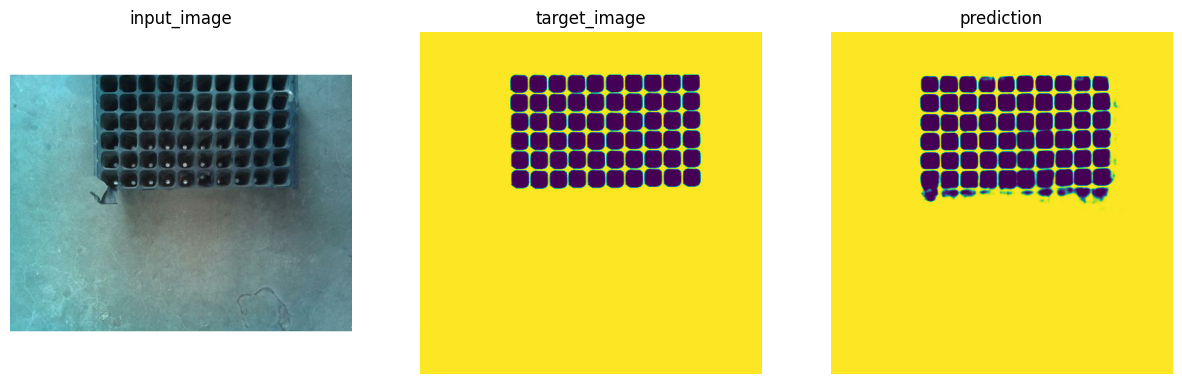

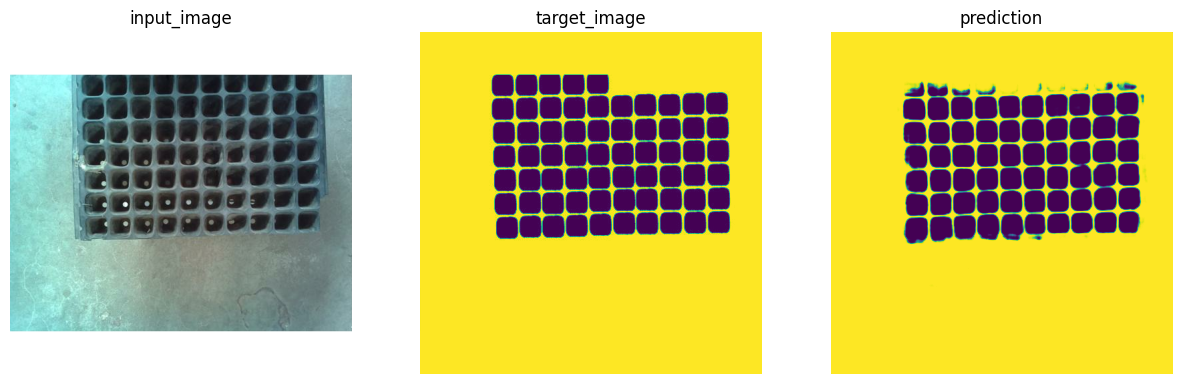

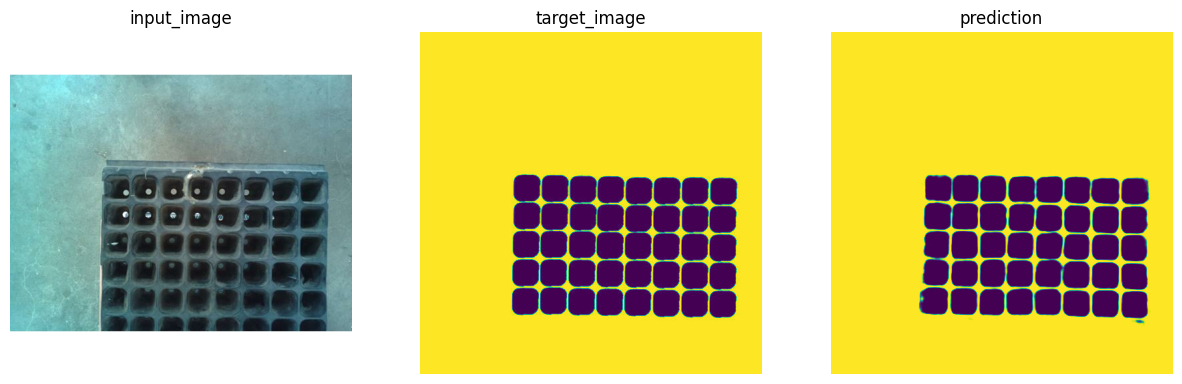

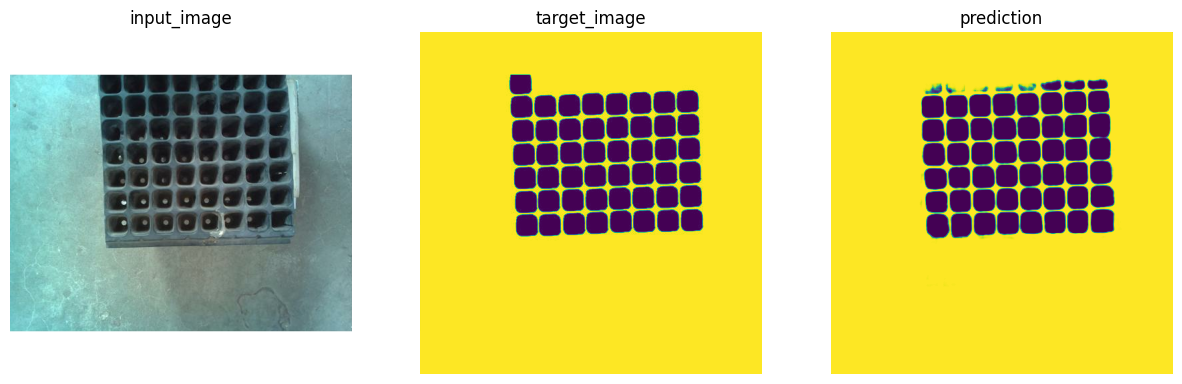

In [38]:
# Correr el modelo de entrenamiento con N ejemplos
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)